<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/Colab_Spectral_Products_L8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

Downloads an existing index and populates the new ODC environment with it.

In [ ]:
from odc_colab import populate_db
populate_db()

# Spectral Products
Spectral products are created using mathematical combinations of specific spectral bands. These spectral products can be useful for identifying spatial variations in vegetation, water or urbanization. This notebook covers the following spectral products: Fractional Cover, NDBI, NDVI, NDWI, SAVI, EVI

In [ ]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

from odc_gee import earthengine
dc = earthengine.Datacube(app='Spectral_Products')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import xarray as xr

In [4]:
# Select a Product and Platform
product = "ls8_google"
platform = "LANDSAT_8"

In [5]:
# Select an analysis region (Latitude-Longitude) 
# Select a time period within the extents of the dataset (Year-Month-Day)

# Mombasa, Kenya
latitude = (-4.15, -3.90) 
longitude = (39.50, 39.75) 

# Define Time Range
# Landsat-8 time range: 07-Apr-2013 to current

# HINT: Use the "Cloud Statistics" notebook to identify clear scenes for given dates. If a time
# window is used, the code will create a median mosaic of all data in that window. 

time_extents = ('2020-01-01', '2020-12-31')

In [6]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Load the dataset and the required spectral bands or other parameters

In [7]:
landsat_dataset = dc.load(latitude=latitude,
                          longitude=longitude,
                          platform=platform,
                          time=time_extents,
                          product=product,
                          measurements=['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

### Mask out clouds and cloud shadows + water (if desired) and create a median mosaic

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
land_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform, cover_types=['clear'])

# Land and Water Dataset = Land and Water pixels with NO Clouds and NO Cloud Shadows
land_and_water_dataset = landsat_dataset.where(cloud_mask)

# Land Dataset = Land ONLY pixels with NO Clouds, NO Cloud Shadows and NO Water pixels
land_dataset = landsat_dataset.where(land_mask)

from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_hdmedians_multiple_band_mosaic


In [9]:
# Select a compositing method to create your cloud-filtered mosaic
# Remove the comments from the pair of lines under one of the mosaic types
# Options are: Median or Max_NDVI 

# This is the MEDIAN mosaic
land_and_water_composite = create_median_mosaic(land_and_water_dataset, cloud_mask)
land_composite = create_median_mosaic(land_dataset, land_mask)
cloud_mask_composite = cloud_mask.max('time')

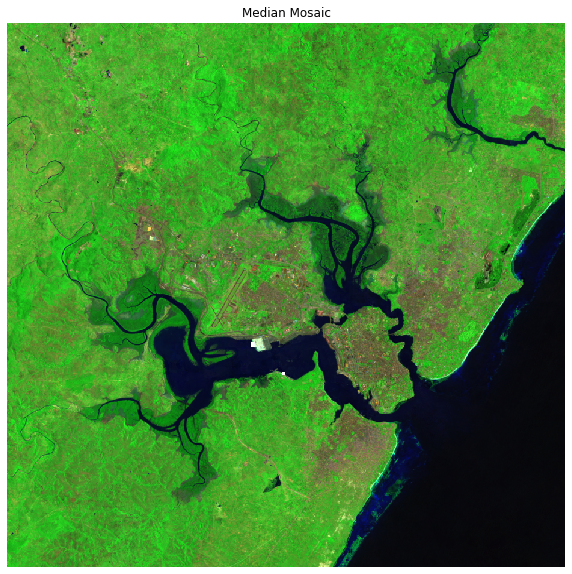

In [10]:
# Show the land and water composite 
from utils.data_cube_utilities.dc_rgb import rgb

# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

median_rgb = land_and_water_composite[['swir2', 'nir', 'green']].to_array()
median_rgb.plot.imshow(vmin=0, vmax=5000, figsize=(10,10))
plt.title("Median Mosaic")
plt.axis('off')
plt.show()

# Land Spectral Indices

In [11]:
def NDBI(dataset):
        return (dataset.swir1 - dataset.nir) / (dataset.swir1 + dataset.nir)

In [12]:
def NDVI(dataset):
    return (dataset.nir - dataset.red) / (dataset.nir + dataset.red)

In [13]:
def NDWI(dataset):
    return (dataset.green - dataset.nir) / (dataset.green + dataset.nir)

In [14]:
def SAVI(dataset):
        return (dataset.nir - dataset.red) / (dataset.nir + dataset.red + 0.5) * 1.5

In [15]:
def EVI(dataset):
        return 2.5 * (dataset.nir - dataset.red) / (dataset.nir + 6.0 * dataset.red - 7.5 * dataset.blue + 1.0)

In [16]:
# Water pixels not masked
ndbi2 = NDBI(land_and_water_composite)  # Normalized Difference Build Up (Urbanization) Index
ndvi2 = NDVI(land_and_water_composite)  # Normalized Difference Vegetation Index
ndwi2 = NDWI(land_and_water_composite) # Normalized Difference Water Index

# Water pixels masked for EVI and SAVI
savi = SAVI(land_composite)  # Soil Adjusted Vegetation Index 
evi = EVI(land_composite) # Enhanced Vegetation Index

In [17]:
ds_ndvi = ndvi2.to_dataset(name="NDVI")
ds_ndwi = ndwi2.to_dataset(name="NDWI")
ds_ndbi = ndbi2.to_dataset(name="NDBI")
normalization_dataset = ds_ndvi.merge(ds_ndwi).merge(ds_ndbi)

### Fractional Cover and Normalized Difference Indices  

Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. We use a model from CSIRO (Juan Gerschmann) and apply it to a median mosaic where: Bare Soil = bs, Photosynthetic Vegetation = pv, and Non-Photosynthetic Vegetation = npv. The product is a False Color RGB result where RGB = bs/pv/npv.

The Normalized Difference product combines NDBI (Build-Up Index), NDVI (Vegetation Index), and NDWI (Water Index) into an RGB image. Differences in vegetation and land types are evident but the contrast is much lower than the Fractional Cover product. 

In [18]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
frac_classes = frac_coverage_classify(land_composite,
                                      clean_mask=np.ones(land_composite.pixel_qa.shape).astype(np.bool)) 

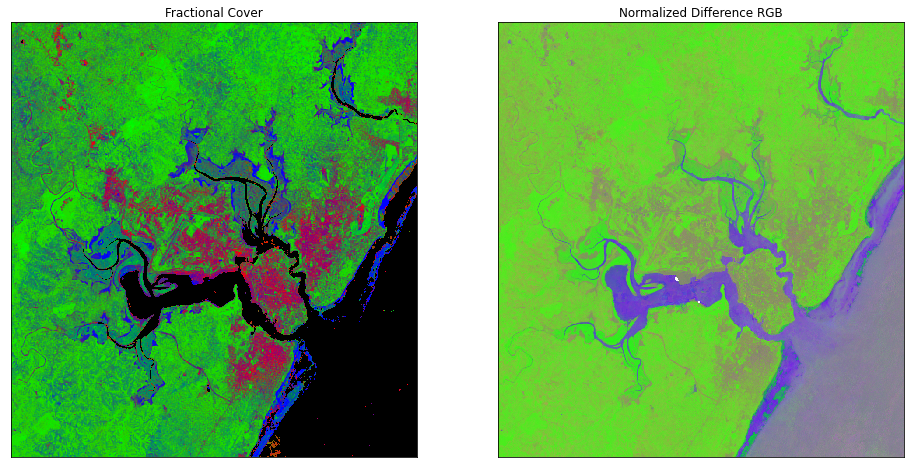

In [19]:
# Plot of Fractional Cover
# RED = Bare Soil or Urban Areas
# BLUE = Non-Green Vegetation
# GREEN = Green Vegetation
# BLACK = Water

# Plot of RGB = NDBI-NDVI-NDWI
# RED = Bare Soil or Urban Areas
# GREEN = Vegetation
# BLUE = Water

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

fc_rgb = frac_classes[['bs', 'pv', 'npv']].to_array()
ndi_rgb = normalization_dataset[['NDBI','NDVI','NDWI']].to_array()

(fc_rgb).plot.imshow(ax=ax[0], vmin=0.0, vmax=100.0)
(ndi_rgb).plot.imshow(ax=ax[1], vmin=-1.0, vmax=1.0)

ax[0].set_title('Fractional Cover'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Normalized Difference RGB'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

In [20]:
%pylab inline
# pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


### Normalized Difference Vegetation Index (NDVI)  

The Normalized Difference Vegetation Index (NDVI) is typically used to measure the "greenness" of vegetation. Differences can be used to assess agriculture health and detect land change (e.g. deforestation). Two sample products are shown below. One uses the common scale (0.0 to 1.0) and the other uses a custom color map to more clearly show different land classes. 

$$NDVI = \frac{(NIR - RED)}{(NIR + RED)}$$

In [21]:
# Create a custom colour map for NDVI
# Water (blue) = NDVI -1.0 to 0.05
# Urban or Bare Soil (brown) = NDVI 0.05 to 0.25
# Low Vegetation (tan) = NDVI 0.25 to 0.4
# Croplands (light green) = NDVI 0.4 to 0.6
# Dense Vegetation / Forests (dark green) = NDVI 0.6 to 1.0

ndvi_cmap = mpl.colors.ListedColormap(['blue', '#a52a2a', '#ffffcc', '#2eb82e', '#006600'])
ndvi_bounds = [-1, 0.05, 0.25, 0.4, 0.6, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

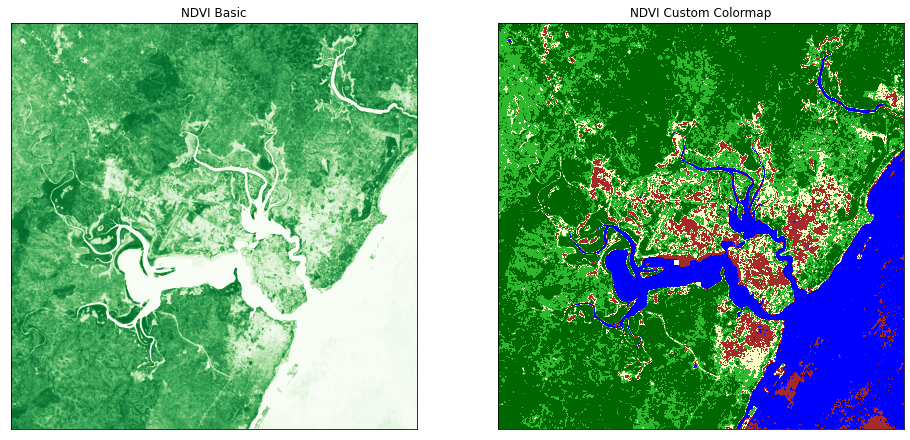

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(ndvi2, cmap="Greens", vmin=0.0, vmax=1.0)
ax[1].imshow(ndvi2, cmap=ndvi_cmap, norm = ndvi_norm, vmin=-1.0, vmax=1.0)
ax[0].set_title('NDVI Basic'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('NDVI Custom Colormap'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

### EVI and SAVI Vegetation Indices

The Enhanced Vegetation Index (EVI) is an 'optimized' vegetation index, compared to common NDVI, designed to enhance the vegetation signal with improved sensitivity in high biomass regions and improved vegetation monitoring through a de-coupling of the canopy background signal and a reduction in atmosphere influences. The coefficients adopted in the EVI algorithm are; L=1, C1 = 6, C2 = 7.5, and G (gain factor) = 2.5.

$$EVI = G \times \frac{(NIR - RED)}{(NIR + C1 \times RED - C2 \times Blue + L)}$$

The Soil Adjusted Vegetation Index (SAVI) is similar to NDVI but minimizes soil brightness influences involving red and near-infrared (NIR) wavelengths. A value of L=0.5 is typically used. 

$$SAVI = \frac{(1 + L)(NIR - RED)}{(NIR + RED + L)}$$

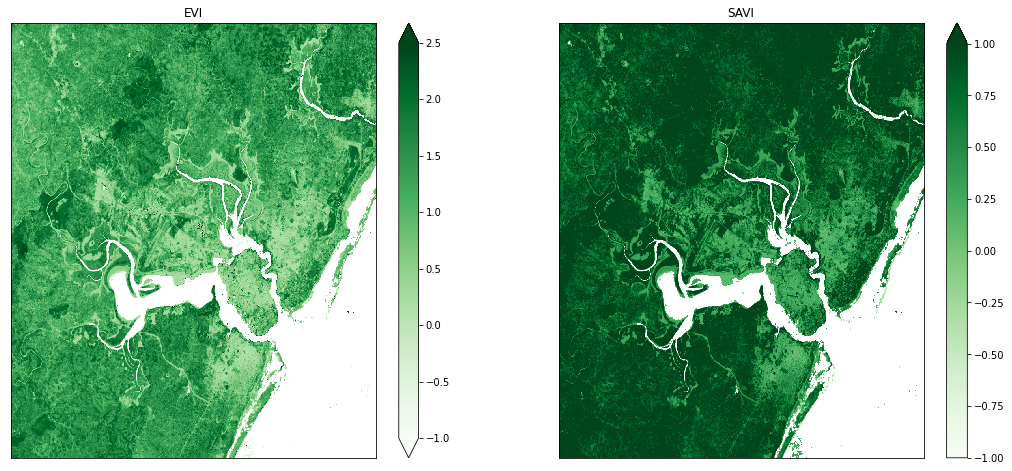

In [23]:
# EVI and SAVI indices using "land only" pixels
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
(evi).plot.imshow(ax=ax[0], cmap="Greens", vmin=-1.0, vmax=2.5)
(savi).plot.imshow(ax=ax[1], cmap="Greens", vmin=-1.0, vmax=1.0)
ax[0].set_title('EVI'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('SAVI'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()